# Constrained optimizations

This recipe gathers patterns to fit constrained optimization problems in a flexible way.
The idea is to have to write little code while having good guarantees with respect to the constraints.
It is also meant to explore how gradient methods can help those optimizations in cases where the full dataset cannot fit in memory.

Approach:
- Let's create a simple example of optimization with non-linear constraints
- Let's test scipy's options
- Let's try to code that ourselves by penalization (L2 penalty on the constraint, with a schedule?)
- coding that by coordinate ascent (one step to optimize, one "dual" step).


In [1]:
import jax
import jax.random as random
import jax.numpy as jnp
import jax.scipy.stats as jst
import matplotlib.pyplot as plt

from functools import partial

import numpy as np

plt.style.use('ggplot')

In [2]:
# Let's try a poisson regression
# with a known total.
# the idea is that we have a training set and test set
# we know x_train, y_train on the training set, but only know x_test and S = sum(y_test) on the test set.
# How do we fit y = f(x) with the constraint that sum(f(x_test)) = sum(y_test)
# Those types of problems are common in advertising, when number of ads is known,
# but frequency is only known on a subset of known users
# y is a Poisson(exp(beta*x)) (Poisson regression)

key = random.PRNGKey(20221211)

n = 10_000 # Sample size
p = 10 # Predictor

key, skey_train, skey_test = random.split(key, 3)
x_train = random.normal(skey_train, (n, p))
x_test = random.normal(skey_test, (n, p))

key, skey = random.split(key)
beta = random.normal(skey, (p,)) / 10

z_train = jnp.exp(x_train @ beta)
key, skey = random.split(key)
y_train = random.poisson(skey, lam=z_train)
key, skey = random.split(key)
y_test = random.poisson(skey, lam=z_train)


In [3]:
y_train.sum(), y_test.sum()

(DeviceArray(11034, dtype=int32), DeviceArray(11006, dtype=int32))

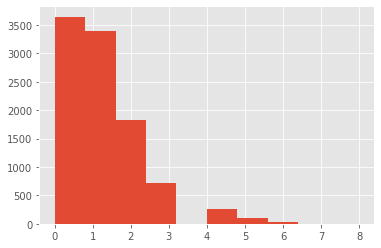

In [4]:
plt.hist(y_train)
plt.show()

In [5]:
# P(y | z) = exp(-z)z**y / z!


def loss(beta, x, y):
    z = jnp.exp(x @ beta)
    log_prob = jst.poisson.logpmf(y, z)
    return -jnp.mean(log_prob)


def constraint(beta):
    return (jnp.exp(x_test @ beta).sum() - y_test.sum()) / y_test.sum()

loss(beta, x_train, y_train), loss(beta, x_test, y_test)

(DeviceArray(1.310571, dtype=float32), DeviceArray(1.5118105, dtype=float32))

In [6]:
# Obviously, even the true beta does not satisfy the constraint.
constraint(beta)

DeviceArray(-0.00865375, dtype=float32)

In [7]:
# let's optimize without constraint, see how close we get.

import jax.scipy.optimize as sco


loss2 = jax.jit(partial(loss, x=x_train, y=y_train))
res = sco.minimize(loss2, jnp.zeros(p), method="BFGS")
beta_hat = res.x

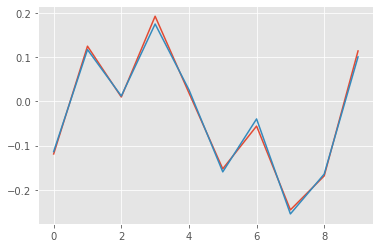

In [8]:
plt.plot(beta)
plt.plot(beta_hat)
plt.show()

In [9]:
y_test_pred = jnp.exp(x_test @ beta_hat)
y_test_pred.sum(), y_test.sum(), y_test_pred.sum() / y_test.sum(), loss(beta_hat, x_test, y_test)
# 2% off, loss is close to true loss.


(DeviceArray(10869.783, dtype=float32),
 DeviceArray(11006, dtype=int32),
 DeviceArray(0.9876234, dtype=float32),
 DeviceArray(1.5075883, dtype=float32))

In [10]:
constraint(jnp.zeros(p))

DeviceArray(-0.09140469, dtype=float32)

In [11]:
from scipy.optimize import minimize

def loss2(beta):
    return np.array(loss(beta, x_train, y_train))

@jax.value_and_grad
def loss2(beta):
    return loss(beta, x_train, y_train)


res = minimize(loss2, x0=np.zeros(p), method='BFGS', jac=True)
res.x - beta_hat

DeviceArray([ 3.5166740e-05, -7.0743263e-05, -4.7573820e-05,
             -5.7116151e-05,  3.6343932e-05,  7.6860189e-05,
              3.9279461e-05,  1.1116266e-04,  6.5565109e-05,
             -2.3782253e-05], dtype=float32)

In [12]:
loss2(beta_hat)

(DeviceArray(1.3099911, dtype=float32),
 DeviceArray([-1.3684046e-06,  2.1009707e-06,  2.8303059e-06,
              -6.7921860e-07, -4.9308724e-06, -2.1517519e-06,
              -3.8401545e-06,  6.7555256e-08,  1.5699975e-06,
               1.5486069e-07], dtype=float32))

In [13]:
%%time

# If we fit with a constraint, sums should be equal and loss might be smaller, since we use more data.

cons = ({'type': 'eq', 'fun': constraint},)

res = minimize(loss2, x0=jnp.zeros(p), constraints=cons, jac=True, method='trust-constr')

CPU times: user 906 ms, sys: 896 ms, total: 1.8 s
Wall time: 608 ms


/home/arthur/prog/jax-stats-cookbook/venv/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


In [14]:
res

         cg_niter: 110
     cg_stop_cond: 2
           constr: [array([0.], dtype=float32)]
      constr_nfev: [1023]
      constr_nhev: [0]
      constr_njev: [0]
   constr_penalty: 34.50639177349873
 constr_violation: 0.0
   execution_time: 0.5967562198638916
              fun: 1.310562252998352
             grad: array([-0.00966398,  0.00947719,  0.00097151,  0.01473893,  0.00153101,
       -0.01390801, -0.00267108, -0.02353565, -0.01565316,  0.01036391],
      dtype=float32)
              jac: [array([[-0.10844959,  0.10639368,  0.01130754,  0.16550128,  0.01747529,
        -0.15624966, -0.02981079, -0.26367131, -0.17629485,  0.11641628]])]
  lagrangian_grad: array([-3.0423237e-06, -6.0665656e-07, -3.5788631e-05, -4.3046680e-06,
       -2.5725238e-05,  1.1062677e-05, -1.5468595e-05, -4.7202459e-05,
        5.1591229e-05, -6.7171577e-06], dtype=float32)
          message: '`xtol` termination condition is satisfied.'
           method: 'equality_constrained_sqp'
             nfev: 93

In [15]:
beta_hat_const = res.x
constraint(beta_hat_const)

DeviceArray(0., dtype=float32)

In [16]:
loss(beta_hat_const, x_train, y_train), loss(beta_hat_const, x_test, y_test)

(DeviceArray(1.3105623, dtype=float32), DeviceArray(1.5214177, dtype=float32))

In [17]:
loss(beta_hat, x_train, y_train), loss(beta_hat, x_test, y_test)

(DeviceArray(1.3099911, dtype=float32), DeviceArray(1.5075883, dtype=float32))

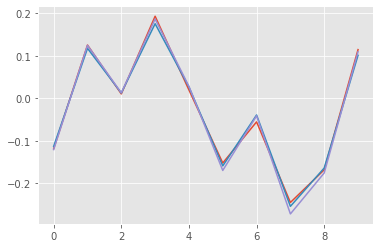

In [18]:
plt.plot(beta)
plt.plot(beta_hat)
plt.plot(beta_hat_const)
plt.show()

In [19]:
# solve by Lagrangian

def lagrangian(beta, lam, x, y):
    return loss(beta, x, y) + lam * constraint(beta)

def lagrangian2(gamma, x, y):
    "gamma: (beta, lam)"
    return lagrangian(gamma[:p], gamma[p], x, y)

lagrangian(beta, 1.0, x_train, y_train)
lagrangian2(np.zeros(p+1), x_train, y_train)

DeviceArray(1.4168301, dtype=float32)

In [20]:
@jax.jit
def loss_lag(gamma, x, y):
    grad = jax.grad(lagrangian2)(gamma, x, y)
    return jnp.square(grad).sum()


In [21]:
%%time
loss_lag(np.zeros(p+1), x_train, y_train)

CPU times: user 177 ms, sys: 0 ns, total: 177 ms
Wall time: 183 ms


DeviceArray(0.23189256, dtype=float32)

In [22]:
@jax.jit
@jax.value_and_grad
def loss_lag2(gamma):
    return loss_lag(gamma, x_train, y_train)


In [23]:
%%time
res = minimize(loss_lag2, x0=np.zeros(p+1), method='BFGS', jac=True)

gamma_hat = res.x
beta_hat_const_lag = gamma_hat[:p]

CPU times: user 272 ms, sys: 35.3 ms, total: 308 ms
Wall time: 313 ms


In [24]:
%%time
loss_lag2(gamma_hat)

CPU times: user 1.28 ms, sys: 0 ns, total: 1.28 ms
Wall time: 851 µs


(DeviceArray(1.3522821e-11, dtype=float32),
 DeviceArray([ 1.1108158e-06,  2.9957032e-06, -2.2715819e-06,
              -2.9599055e-06,  2.1862807e-06, -1.6740086e-06,
              -3.2022333e-06, -2.5822278e-06, -3.0113913e-06,
               7.3852402e-07,  9.8051942e-07], dtype=float32))

In [25]:
loss(beta_hat_const_lag, x_train, y_train), constraint(beta_hat_const_lag)

(DeviceArray(1.3105623, dtype=float32),
 DeviceArray(4.4365007e-07, dtype=float32))

In [26]:
loss(beta_hat_const_lag, x_test, y_test), constraint(beta_hat_const_lag)

(DeviceArray(1.5214193, dtype=float32),
 DeviceArray(4.4365007e-07, dtype=float32))

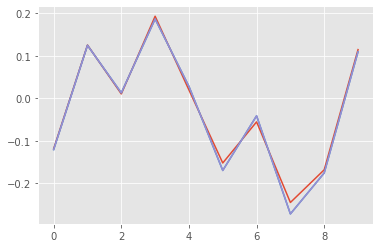

In [27]:
plt.plot(beta)
plt.plot(beta_hat_const)
plt.plot(beta_hat_const_lag)
plt.show()

# That works pretty well.